### Zadania

(W nawiasach podana jest osobno punktacja części praktycznej i teoretycznej.)

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

##### Zad. 1: Mapa ciepła (0.75 pkt | 0.5 pkt)

Wykonaj dla obrazu `coins` sztuczny obraz ilustrujący wielkość (moduł) wektora gradientu w danym punkcie – w zależności od wartości, oznacz piksel odpowiednim kolorem – im większa wartość, tym bardziej czerwony (_mapa ciepła_).

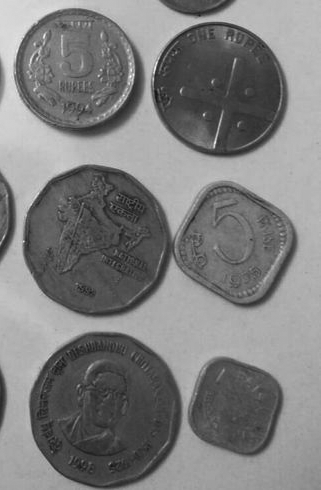

In [2]:
coins = cv2.imread('Monety_szare.bmp', cv2.IMREAD_GRAYSCALE)
Image.fromarray(coins)

Rozwiązanie:

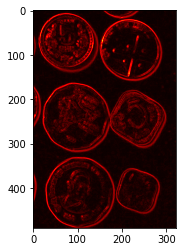

In [4]:
gX = cv2.Sobel(coins, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
gY = cv2.Sobel(coins, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)

magnitude = np.sqrt((gX ** 2) + (gY ** 2)).astype(int)
# magnitude = cv2.convertScaleAbs(magnitude)

plt.imshow(magnitude, cmap='hot')
plt.savefig('zad1.png')

---

##### Zad. 2: Detekcja krawędzi (0.75 pkt | 0.5 pkt)

Przeprowadź z obrazem `coins_noise` takie przekształcenia, aby zmaksymalizować możliwość rozpoznania obiektów poprzez detekcję krawędzi. Wykorzystaj filtr Canny'ego dla różnych wartości progów oraz filtry redukcji szumu.

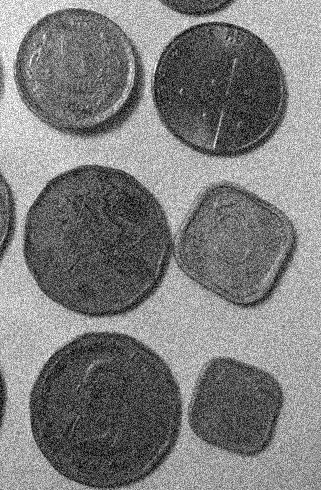

In [5]:
coins_noise = cv2.imread('Monety_szare_szum.bmp', cv2.IMREAD_GRAYSCALE)
Image.fromarray(coins_noise)

Rozwiązanie:

In [11]:
def filter_gauss(img, kernel_size):
    filtered_img = cv2.GaussianBlur(img,(kernel_size, kernel_size),cv2.BORDER_DEFAULT)
    return filtered_img

def filter_mean(img, size):
    kernel_blur_matrix = np.ones((size,size)) / (size**2)
    filtered_img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel_blur_matrix)
    return filtered_img

def run_canny(img, t1, t2):
    return cv2.Canny(image=img, threshold1=t1, threshold2 = t2)


def test_run(img, filter_type='gauss'):
    f, ((a1, a2, a3), (a4, a5, a6), (a7, a8, a9)) = plt.subplots(3, 3)
    f.set_figwidth(15)
    f.set_figheight(25)
    
    for ax, t1, t2,ks in zip([a1, a2, a3, a4, a5, a6, a7, a8, a9], [50, 100, 200, 50,100,200, 50, 100, 200], [200,200, 300,200,200,350, 200, 200, 350],[3,3,3,5,5,5,7,7,7]):
        if filter_type == 'gauss':
            ax.imshow(cv2.Canny(image=filter_gauss(img, ks), threshold1=t1, threshold2 = t2), cmap='gray');
        elif filter_type == 'mean':
            ax.imshow(cv2.Canny(image=filter_mean(img, ks), threshold1=t1, threshold2 = t2), cmap='gray');    
        ax.set_title('próg dolny = {}\npróg górny = {}\nfilter= {}\nrozmiar kernela {}'.format(t1, t2, filter_type, ks))

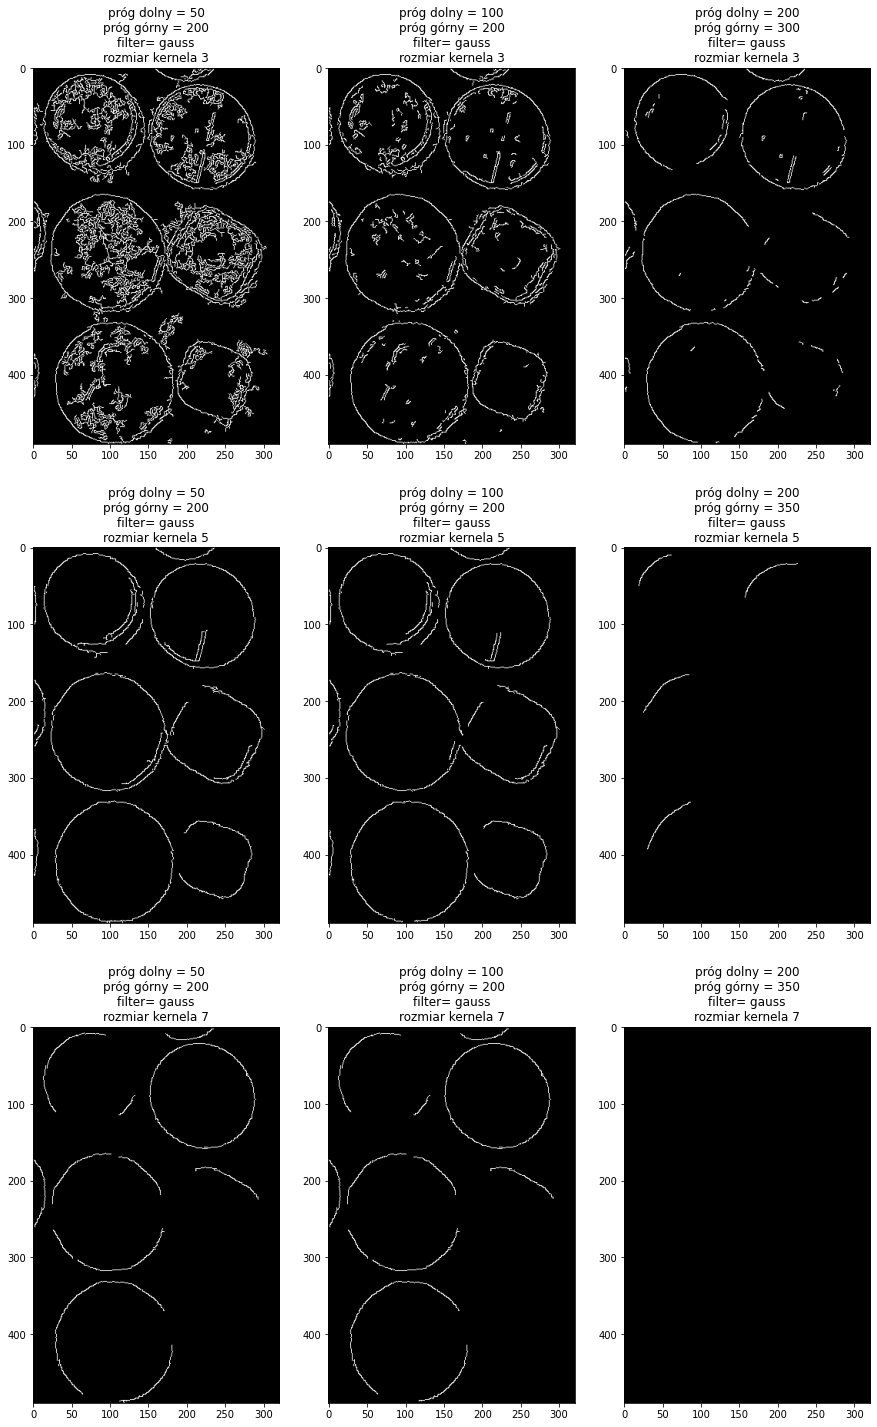

In [13]:
test_run(coins_noise, 'gauss')
plt.savefig('zad2.png')

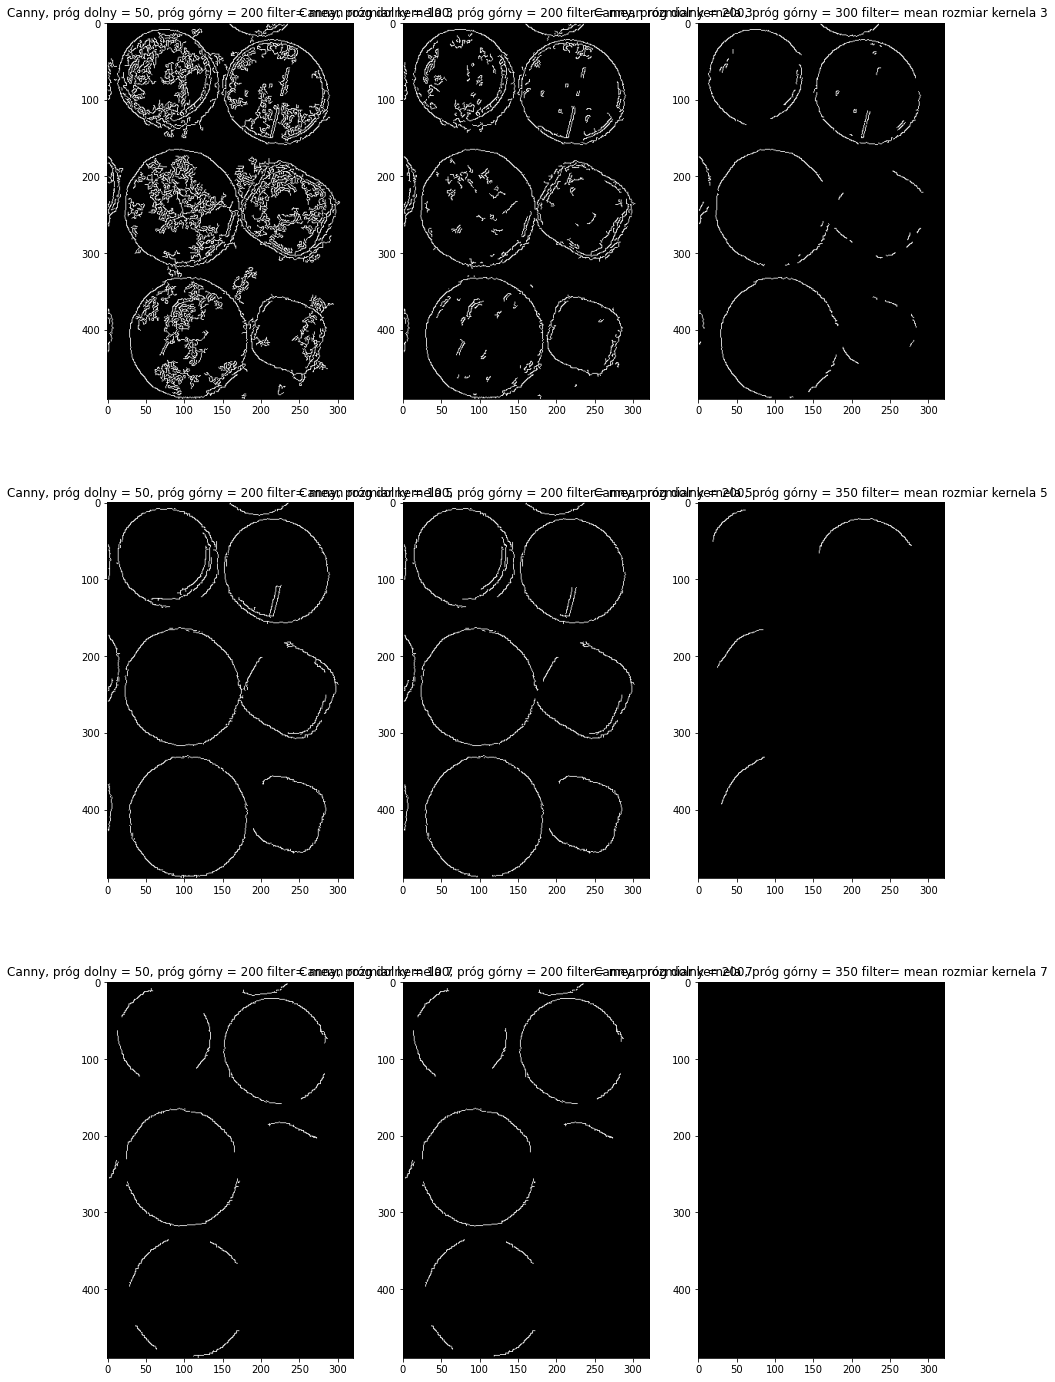

In [8]:
test_run(coins_noise, 'mean')

---

##### Zad. 3: Wyrównanie histogramu (0.5 pkt | 0.5 pkt)

Wyrównaj histogram obrazu `coins_noise`. Wyniki zaprezentuj za pomocą obrazów i towarzyszących im histogramów.

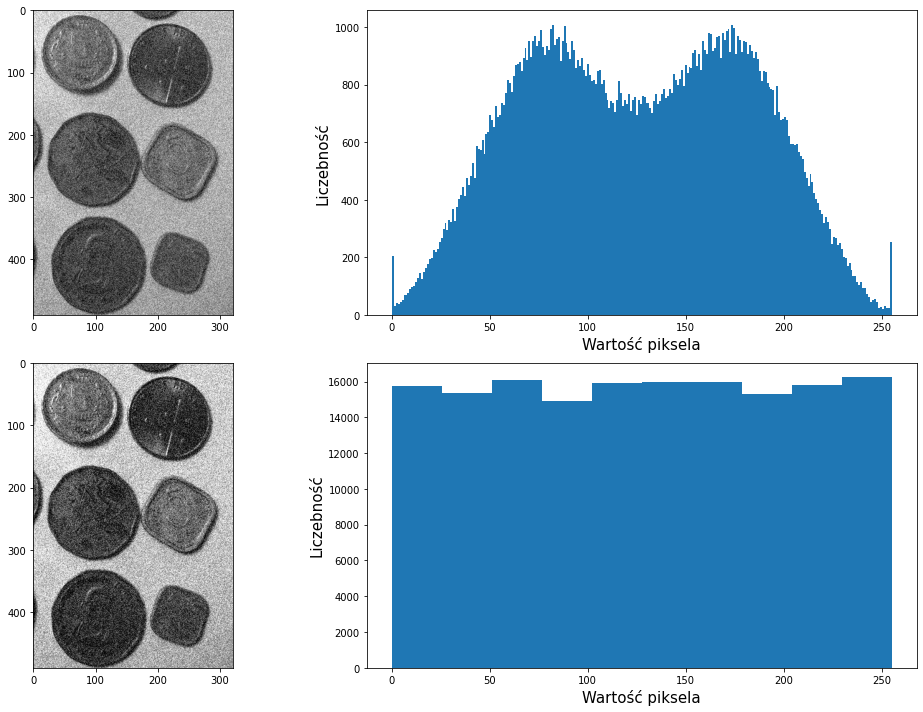

In [24]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0][0].imshow(coins_noise, cmap='gray');
ax[0][1].hist(coins_noise.flatten(), bins=256);
ax[0][1].set_xlabel('Wartość piksela', fontsize=15);
ax[0][1].set_ylabel('Liczebność', fontsize=15)
equalized_hist = cv2.equalizeHist(coins_noise);
ax[1][0].imshow(equalized_hist, cmap='gray');
ax[1][1].hist(equalized_hist.flatten());
ax[1][1].set_xlabel('Wartość piksela', fontsize=15);
ax[1][1].set_ylabel('Liczebność', fontsize=15)
plt.tight_layout()
# plt.show()
plt.savefig('zad3v1.png')

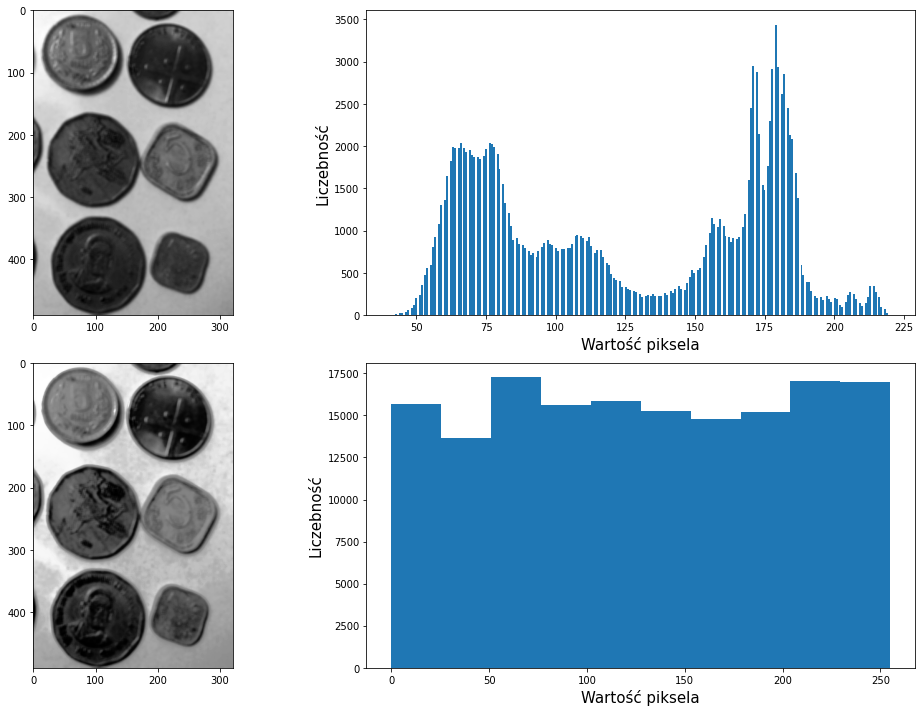

In [26]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

filtered_coins = filter_mean(coins, 5);
ax[0][0].imshow(filtered_coins, cmap='gray');
ax[0][1].hist(filtered_coins.flatten(), bins=256);
ax[0][1].set_xlabel('Wartość piksela', fontsize=15);
ax[0][1].set_ylabel('Liczebność', fontsize=15);
equalized_hist_filtered = cv2.equalizeHist(filtered_coins);
ax[1][0].imshow(equalized_hist_filtered, cmap='gray');
ax[1][1].hist(equalized_hist_filtered.flatten());
ax[1][1].set_xlabel('Wartość piksela', fontsize=15);
ax[1][1].set_ylabel('Liczebność', fontsize=15);

plt.tight_layout();
plt.savefig('zad3v2.png')

---

##### Zad. 4: Transformacja do rozkładu docelowego (1.0 pkt | 0.5 pkt)

Dla obrazów `hare_gray` i `hare_color` wykonaj transformacje na składowych S i/lub V modelu HSV, przechodząc do wybranego (założonego) rozkładu docelowego, tak aby zmaksymalizować możliwość wyodrębnienia obiektu z otoczenia (zająca) przy użyciu algorytmu binaryzacji Otsu.

Podpowiedź: przedstawiona we wstępie teoretycznym transformacja obu rozkładów (źródłowego i docelowego) do rozkładu jednostajnego _nie musi_ zostać faktycznie wykonana (dlatego nie używaj w zadaniu funkcji `cv2.equalizeHist`)! Wystarczy porównywanie ze sobą wartości ze skumulowanych rozkładów (rysunek 3).

Podpowiedź 2: [cv2.LUT](https://docs.opencv.org/4.5.3/d2/de8/group__core__array.html#gab55b8d062b7f5587720ede032d34156f)

**4A** (`hare_gray`):

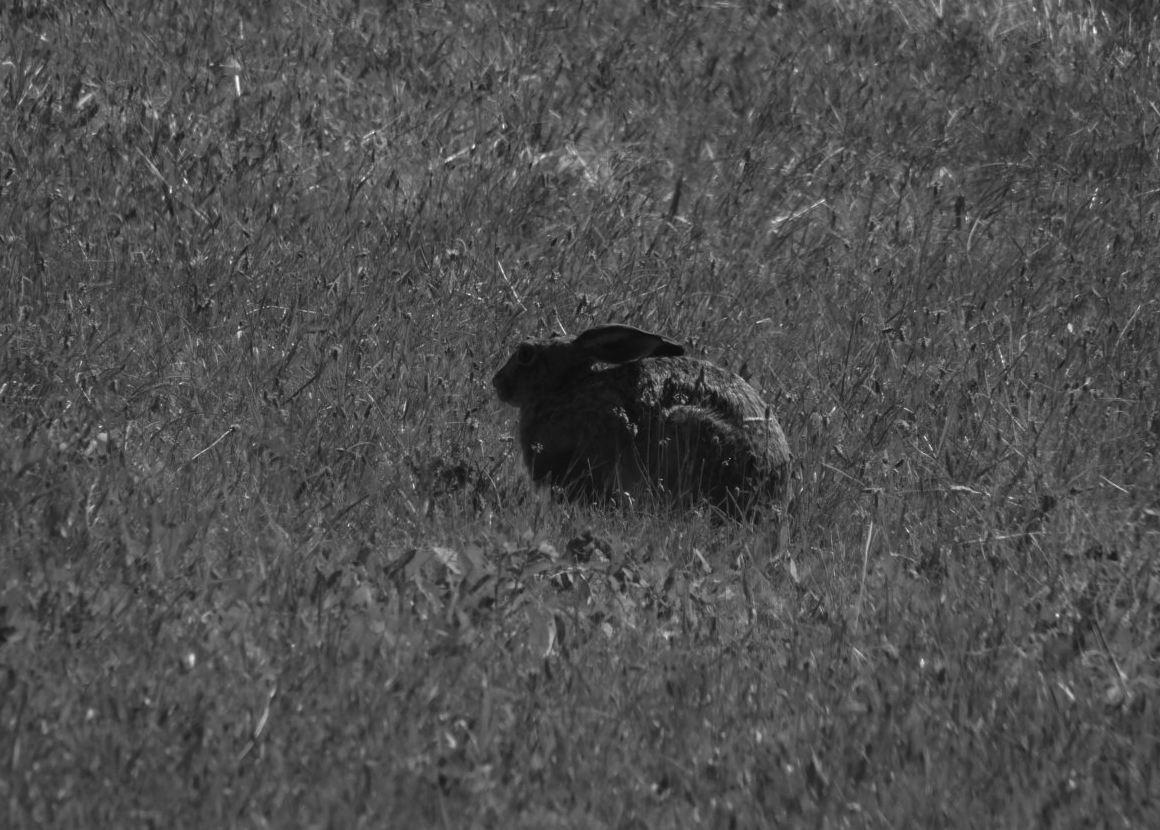

In [27]:
hare_gray = cv2.imread('Zajac.jpg', cv2.IMREAD_GRAYSCALE)
Image.fromarray(hare_gray)

Rozwiązanie:

In [53]:
# method 1
import scipy
from scipy.stats import norm, truncnorm


def move_hist(img, means=[50,200], var=[30,40]):
    lower, upper = 0, 255
    m1, m2 = means
    var1, var2 = var

    N = len(hare_gray.flatten())
    normal_dist_1 = truncnorm((lower - m1) / var1, (upper - m1) / var1, loc=m1, scale=var1).rvs(N)
    normal_dist_2 = truncnorm((lower - m2) / var2, (upper - m2) / var2, loc=m2, scale=var2).rvs(N)

    bimodal = np.concatenate([normal_dist_1, normal_dist_2])

    image_hist = np.histogram(img.flatten(), bins=256)
    bimodal_hist = np.floor(bimodal)

#     fig, ax = plt.subplots(1,2,figsize=(10,5))
#     ax[1].hist(bimodal_hist,density=True, bins=256)
#     ax[0].hist(img.flatten(), bins=256,density=True)
    
    
    count1, bins_count1 = np.histogram(img.flatten(), bins=256)
    count2, bins_count2 = np.histogram(bimodal, bins=256)
    
    pdf1 = count1 / sum(count1)
    pdf2 = count2 / sum(count2)
    
    cdf1 = np.cumsum(pdf1)
    cdf2 = np.cumsum(pdf2)
    
#     fig, ax = plt.subplots(1,2,figsize=(10,5))
#     ax[0].plot(cdf1)
#     ax[1].plot(cdf2)
    
    after_lut = cv2.LUT(img, cdf2)
    return after_lut, bimodal_hist, cdf1, cdf2


from matplotlib.gridspec import SubplotSpec
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [54]:
lut_img,bimodal_hist, cdf1, cdf2 = move_hist(hare_gray)

In [58]:
def plot_4(img, lut_img, bimodal_hist, cdf1, cdf2):
    fig, ax = plt.subplots(3,2,figsize=(12,10))


    ax[0][0].hist(img.flatten(), bins=256, density=True)
    ax[0][0].set_xlabel('Wartość piksela')
    ax[0][0].set_ylabel('Liczebność')
    ax[0][1].hist(bimodal_hist, density=True, bins=256)
    ax[0][1].set_xlabel('Wartość piksela')
    ax[0][1].set_ylabel('Liczebność')
    ax[1][0].plot(cdf1)
    ax[1][0].set_xlabel('Wartość piksela')
    ax[1][0].set_ylabel('$F(x)$')
    ax[1][1].plot(cdf2)
    ax[1][1].set_xlabel('Wartość piksela')
    ax[1][1].set_ylabel('$F(x)$')
    ax[2][0].imshow(img, cmap='gray')
    ax[2][1].imshow(lut_img, cmap='gray')

    grid = plt.GridSpec(3, 2)
    create_subtitle(fig, grid[0, ::], 'Histogramy')
    create_subtitle(fig, grid[1, ::], 'Dystrybuanty rozkładów')
    create_subtitle(fig, grid[2, ::], 'Obrazy')

    plt.tight_layout()

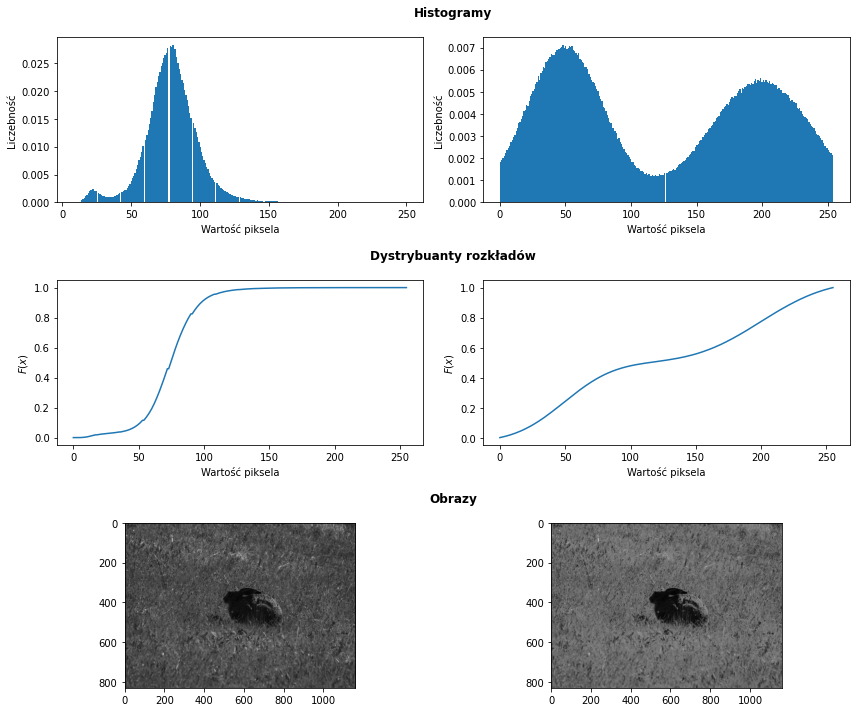

In [60]:
plot_4(hare_gray, lut_img, bimodal_hist, cdf1, cdf2)
plt.savefig('zad4v1.png')

In [67]:
lut_img,bimodal_hist, cdf1, cdf2 = move_hist(hare_gray, [30,230],[10,40])

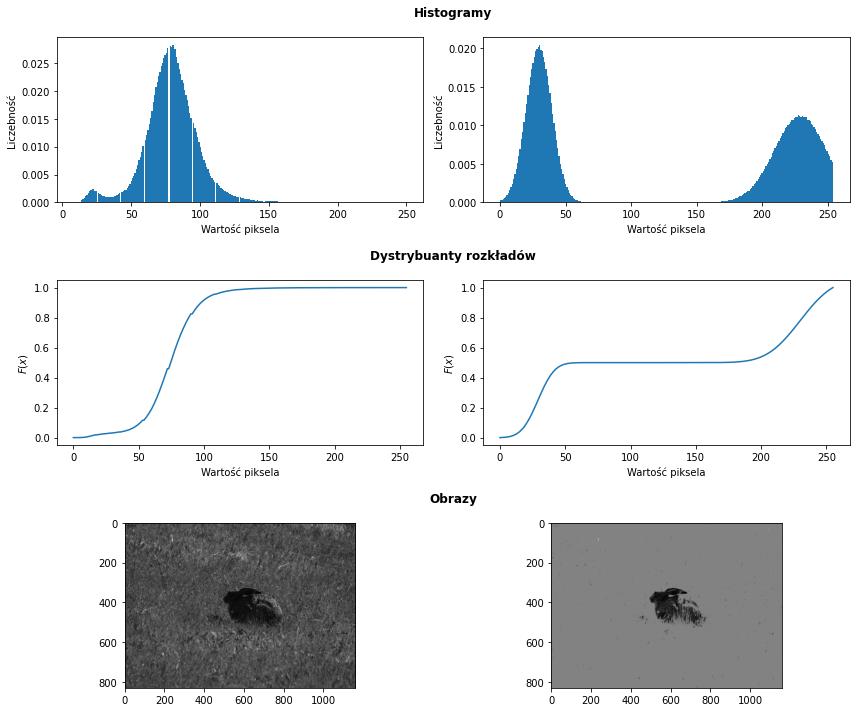

In [68]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(hare_gray, cmap='gray')
ax[1].imshow(lut_img2, cmap='gray')

---

**4B** (`hare_color`):

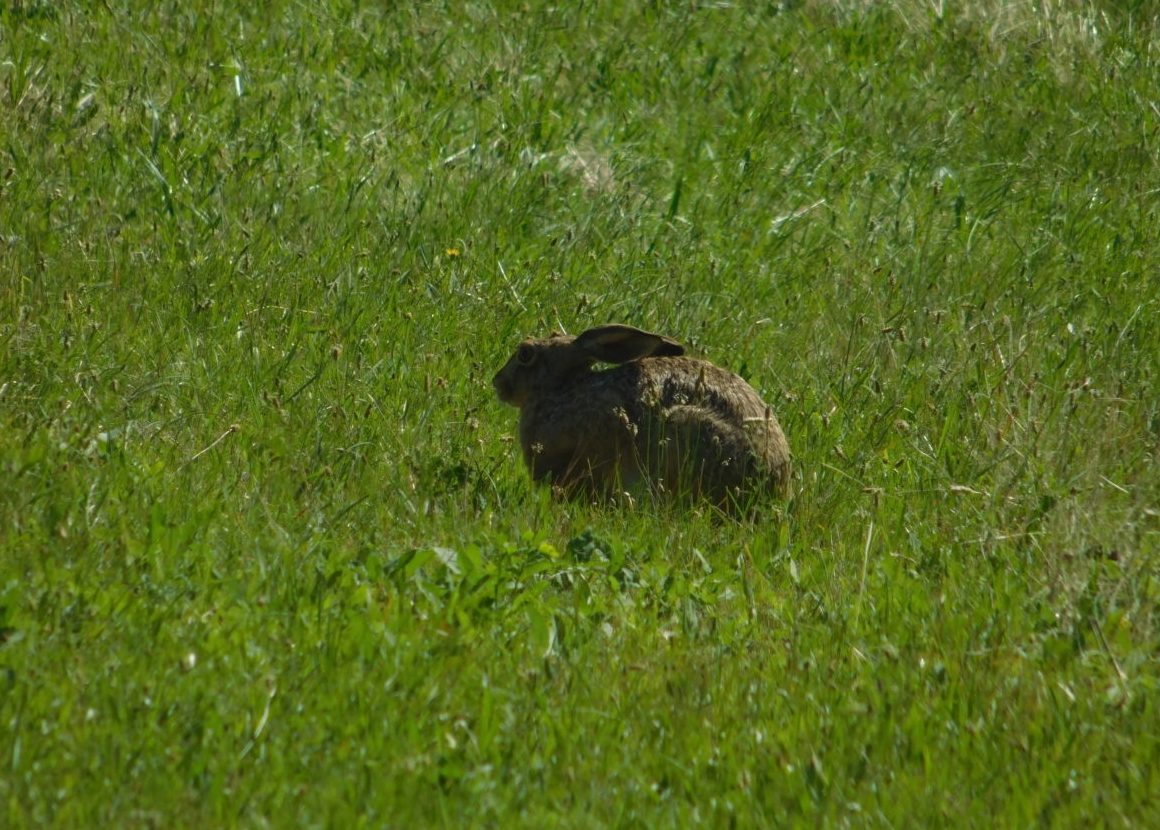

In [69]:
hare_color = cv2.imread('Zajac_kolor.jpg')
Image.fromarray(hare_color[..., ::-1]) # taki pro-tip

Rozwiązanie:

In [110]:
hare_hsv = cv2.cvtColor(hare_color, cv2.COLOR_BGR2HSV)

Image.fromarray(hare_hsv)


hare_hsv_H = hare_hsv[:,:,1]
hare_hsv_S = hare_hsv[:,:,0]
hare_hsv_V = hare_hsv[:,:,2]

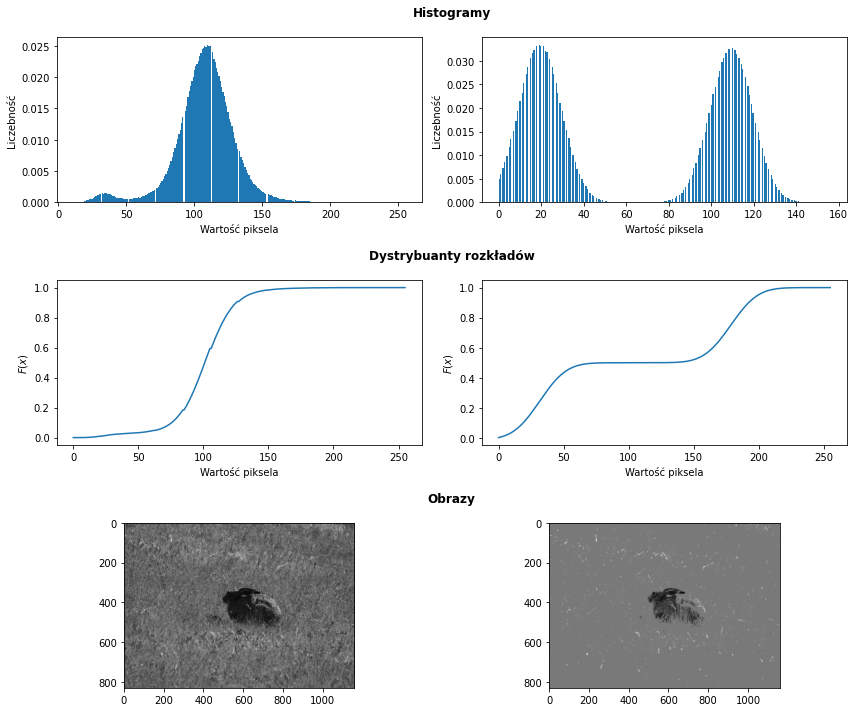

In [116]:
lut_img, bimodal_hist, cdf1, cdf2 = move_hist(hare_hsv_V, [20, 110], [10,10])
plot_4(hare_hsv_V, lut_img, bimodal_hist, cdf1, cdf2)
plt.savefig('zad4hsv.png')

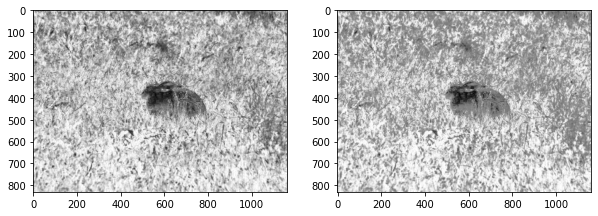

In [171]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(hare_hsv_H, cmap='gray')
ax[1].imshow(lut_img_H, cmap='gray')

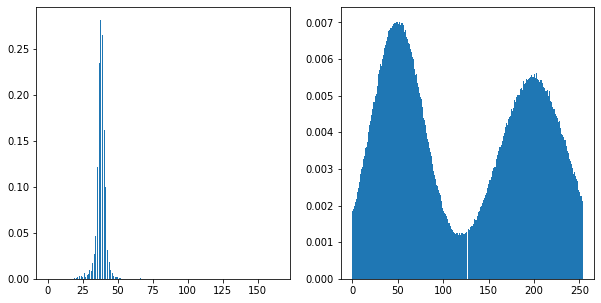

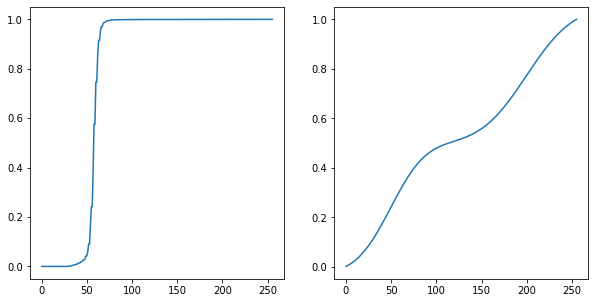

In [172]:
lut_img_S = move_hist(hare_hsv_S)

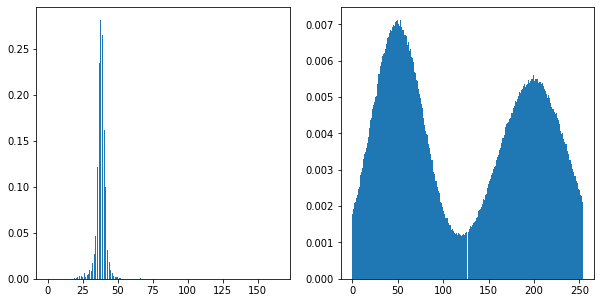

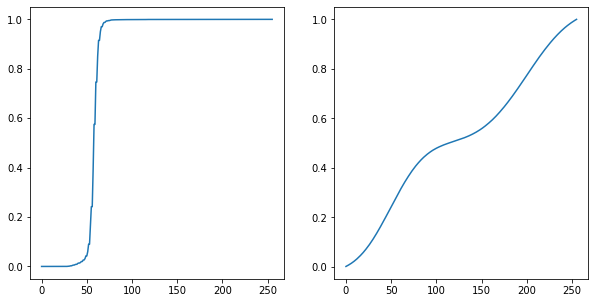

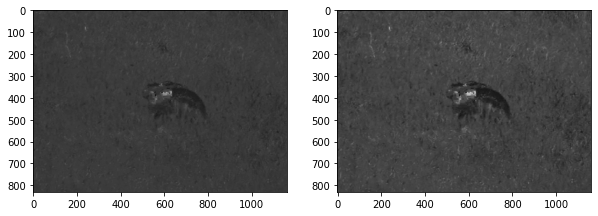

In [173]:
lut_img_S = move_hist(hare_hsv_S)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(hare_hsv_S, cmap='gray')
ax[1].imshow(lut_img_S, cmap='gray')

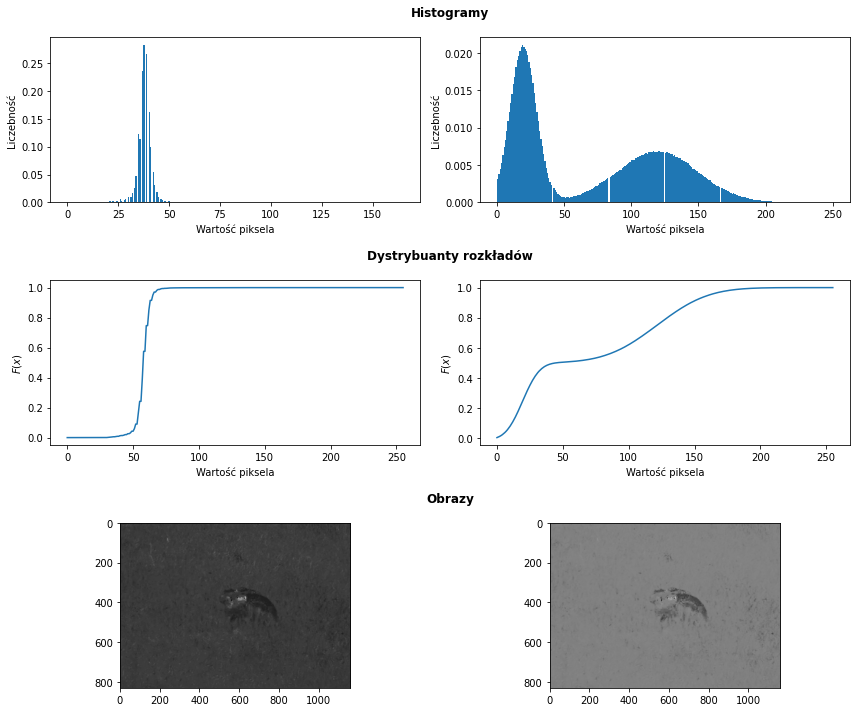

In [109]:
lut_img, bimodal_hist, cdf1, cdf2 = move_hist(hare_hsv_S, [20, 120], [10,30])
plot_4(hare_hsv_S, lut_img, bimodal_hist, cdf1, cdf2)